In [22]:
import pandas as pd
import numpy as np
import datetime
import plotly
from plotly import graph_objects as go
pd.set_option('display.max_rows', 100)

%load_ext autoreload

from charts import plot_line, plot_bar, plot_peak, print_charts_country
from features import add_variables_covid, add_variables_apple, join_series_day_since, join_series_date

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
date_apple = '2020-05-10'

In [38]:
def apple_filter_region(df, region):
    df_region = df[df.region == region].T
    df_region.columns = df_region.loc['transportation_type', :]
    df_region = df_region[~df_region.index.isin(['geo_type', 'region', 'transportation_type', 'alternative_name'])]
    
    df_region['dates'] = pd.to_datetime(df_region.index)
    df_region.set_index('dates', inplace=True)
    df_region = df_region.astype('float')
    df_region['region'] = region
    
    return df_region

In [26]:
def add_forecast_prophet(df_in, column, window=60, ):
    from fbprophet import Prophet
    df = df_in.loc[:, [column]].dropna()
    df['ds'] = df.index
    df.columns = ['y', 'ds']
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=window)
    forecast = m.predict(future)
    forecast.set_index(forecast.ds, inplace=True)
    forecast = forecast.loc[:, ['yhat', 'yhat_lower', 'yhat_upper']]
    df_extra_dates = pd.DataFrame({ 'day': pd.Series([max(df_in.index) + datetime.timedelta(1), max(df_in.index) + datetime.timedelta(window)])})
    df_extra_dates.set_index('day',inplace=True)
    df_extra_dates = df_extra_dates.asfreq('D')
    df_in = df_in.append(df_extra_dates)
    df_result = pd.concat([df_in, forecast ], axis=1)
    df_result[f'{column}_pred'] = df_result.loc[df_result[column].isnull() == True, ['yhat']]
    
    return df_result


In [97]:
def prepare_df_country(df_confirmed, df_dead, country, date_cutoff='2020-03-15'):
    try:
        pop = df_population.loc[df_population.country == country, 'population'].values[0]
    except:
        print('No population data for :', country)
        return False
    
    df = df_confirmed.loc[df_confirmed.index >= date_cutoff, [country]]
    df.columns = ['confirmed']
    df = add_variables_covid(df, population=pop)

    df_d = df_dead.loc[df_dead.index >= date_cutoff, [country]]
    df_d.columns = ['dead']
    df = df.merge(df_d, left_index=True, right_index=True)
    df = add_variables_covid(df, column='dead', population=pop)
    
    return df

In [52]:
def melt_apple_df(df_apple):
    _list = list()
    for region in df_apple.region.unique():
        df = apple_filter_region(df_apple, region)
        df = add_variables_apple(dfapple_region)
        _list.append(df)
    return pd.concat([df for df in _list])

In [ ]:
def melt_rki_df(df_rki_germany):
    _list = list()
    for land in df_rki_germany.land.unique():
        df = df_rki_germany.loc[df_rki_germany.land == land, :].copy()
        pop = int(df.loc[df.land==land, 'population'][0])
        df = add_variables_covid(df, 'confirmed', population=pop)
        df = add_variables_covid(df, 'dead', population=pop)
        _list.append(df)
    return pd.concat([df for df in _list])

In [107]:
type(df_apple_processed) == pd.core.frame.DataFrame

True

In [109]:
def melt_jhu_df(df_confirmed, df_dead):
    _list = list()
    for country in df_confirmed.columns:
        df = prepare_df_country(df_confirmed, df_dead, country, date_cutoff='2020-03-15')
        if type(df) == pd.core.frame.DataFrame:
            _list.append(df)
    pd.concat([df for df in _list])

# World Bank Data

In [28]:
import world_bank_data as wb

countries = wb.get_countries()

# population = wb.get_series('SP.POP.TOTL', mrv=1)  # Most recent value
population = wb.get_series('SP.POP.TOTL', id_or_value='id', simplify_index=True, mrv=1)

# Aggregate region, country and population
df_population = countries[['region', 'name']].rename(columns={'name': 'country_wb'}).loc[countries.region != 'Aggregates']
df_population['population'] = population
df_population['country_wb'] = df_population['country_wb'].astype('string')
df_population['iso_code'] = df_population.index
df_population.head(1)

,region,country_wb,population,iso_code
id,,,,
ABW,Latin America & Caribbean,Aruba,105845.0,ABW


In [29]:
date_now = datetime.datetime.strftime(datetime.datetime.utcnow(), "%Y-%m-%d")

dfapple = pd.read_csv(f"../AppleMobilty/applemobilitytrends-{date_apple}.csv")

dfcovid_conf = pd.read_csv("../covid-19-JHU CSSE/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
dfcovid_dead = pd.read_csv("../covid-19-JHU CSSE/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df_uid = pd.read_csv("../covid-19-JHU CSSE/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

df_uid = df_uid.loc[df_uid['Province_State'].isnull() == True, ['iso3', 'Country_Region']]
df_uid.columns = ['iso_code', 'country']

dfcovid_conf.columns = ['state', 'country', 'lat', 'lng'] + list(dfcovid_conf.columns[4:])
dfcovid_dead.columns = ['state', 'country', 'lat', 'lng'] + list(dfcovid_dead.columns[4:])
dfcovid_conf = dfcovid_conf.merge(df_uid, how='outer', on='country', suffixes=('_x', '_y'))
dfcovid_dead = dfcovid_dead.merge(df_uid, how='outer', on='country', suffixes=('_x', '_y'))

df_rki_germany = pd.read_csv("data-RKI-parse/RKI-reports.csv")
df_rki_germany.drop('data', axis=1, inplace=True)

df_population_de = pd.read_csv('german_lander_population.csv')

In [30]:
# dfcovid_conf.loc[dfcovid_conf['country'] == 'China',:].reset_index()

In [31]:
dfcovid_conf = dfcovid_conf.loc[dfcovid_conf['state'].isnull() == True, :]
dfcovid_dead = dfcovid_dead.loc[dfcovid_dead['state'].isnull() == True, :]

In [32]:
df_population = df_population.merge(dfcovid_conf.loc[:, ['iso_code', 'country']].drop_duplicates(), how='inner',  on='iso_code',  suffixes=('_x', '_y'), left_index=False, right_index=False,)

In [33]:
df_population.head()

,region,country_wb,population,iso_code,country
0,South Asia,Afghanistan,37172386.0,AFG,Afghanistan
1,Sub-Saharan Africa,Angola,30809762.0,AGO,Angola
2,Europe & Central Asia,Albania,2866376.0,ALB,Albania
3,Europe & Central Asia,Andorra,77006.0,AND,Andorra
4,Middle East & North Africa,United Arab Emirates,9630959.0,ARE,United Arab Emirates


## Join Population data

In [34]:
df_rki_germany = df_rki_germany.merge(df_population_de, 
                                            how='inner',
                                            left_on='land',
                                            right_on='name',
                                            left_index=False,
                                            right_index=False,
                                            suffixes=('_x', '_y'),)

### Add index to RKI data

In [35]:
df_rki_germany['date'] = df_rki_germany['date'].astype('datetime64[ns]')
df_rki_germany = df_rki_germany.sort_values('date', ascending=True)
df_rki_germany.set_index('date', inplace=True)

## Calculate all German States

### Transpose Confirmed Cases

In [16]:
dfcovid_conf_t = dfcovid_conf.loc[dfcovid_conf['state'].isnull() == True, :].T
dfcovid_conf_t.columns = dfcovid_conf_t.loc['country', :].astype(str)
dfcovid_conf_t.drop(['country'], axis=0, inplace=True)
df_country_coords = dfcovid_conf_t.loc[['lat', 'lng'], :]
dfcovid_conf_t.drop(['lat', 'lng', 'state', 'iso_code'], axis=0, inplace=True)
dfcovid_conf_t['dates'] = dfcovid_conf_t.index
dfcovid_conf_t['dates'] = dfcovid_conf_t['dates'].astype('datetime64[ns]')
dfcovid_conf_t = dfcovid_conf_t.sort_values('dates', ascending=True)
dfcovid_conf_t.set_index('dates', inplace=True)
dfcovid_conf_t = dfcovid_conf_t.astype(float)

### Transpose Dead Cases

In [17]:
dfcovid_dead_t = dfcovid_dead.loc[dfcovid_dead['state'].isnull() == True, :].T
dfcovid_dead_t.columns = dfcovid_dead_t.loc['country', :].astype(str)
dfcovid_dead_t.drop(['country'], axis=0, inplace=True)


dfcovid_dead_t.drop(['lat', 'lng', 'state', 'iso_code'], axis=0, inplace=True)
dfcovid_dead_t['dates'] = dfcovid_dead_t.index
dfcovid_dead_t['dates'] = dfcovid_dead_t['dates'].astype('datetime64[ns]')
dfcovid_dead_t = dfcovid_dead_t.sort_values('dates', ascending=True)
dfcovid_dead_t.set_index('dates', inplace=True)
dfcovid_dead_t = dfcovid_dead_t.astype(float)


# Prepare Datasets

### RKI

In [54]:
df_rki_germany_processed = melt_rki_df(df_rki_germany)

In [57]:
df_rki_germany_processed.head(1)

,land,confirmed,dead,name,iso_code,capital,area,population,dow,weekend,...,dead_change_pct_3w,dead_change_acceleration,dead_change_acceleration_avg3,dead_doubling_days,dead_doubling_days_3w,dead_doubling_days_avg3,dead_doubling_days_3w_avg3,dead_day_since_10,dead_per_100k,dead_change_per_100k
date,,,,,,,,,,,,,,,,,,,,,
2020-03-18,Hesse,432,0,Hesse,HE,Wiesbaden,21115,6265809,2,False,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0,0.0,NaN


### Apple

In [47]:
df_apple_processed = melt_apple_df(dfapple)

In [58]:
df_apple_processed.head(1)

transportation_type,driving,transit,walking,region,transit_avg3,transit_l1,transit_l6,change_transit_l6,change_transit,walking_avg3,walking_l1,walking_l6,change_walking_l6,change_walking,driving_avg3,driving_l1,driving_l6,change_pct_driving_l6,change_driving
dates,,,,,,,,,,,,,,,,,,,
2020-01-13,100.0,100.0,100.0,Hamburg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### JHU

In [110]:
df_jhu_processed = melt_jhu_df(dfcovid_conf_t, dfcovid_dead_t)

No population data for : Diamond Princess
No population data for : Holy See
No population data for : Kosovo
No population data for : MS Zaandam
No population data for : Western Sahara


In [111]:
df_jhu_processed.head(1)

AttributeError: 'NoneType' object has no attribute 'head'

In [ ]:
print("Mobility max date:", max(df_apple_processed.index))
print("RKI max date", max(df_rki_germany_processed.index))
print("Covi world max date", max(dfcovid_conf_t.index))
print("Covi world max date", max(dfcovid_dead_t.index))

# Save processed data

In [59]:
df_rki_germany_processed.to_csv('data_rki_prepared.csv')
df_apple_processed.to_csv('data_apple_prepared.csv')

In [121]:
df_rki_germany_processed.columns

Index(['land', 'confirmed', 'dead', 'name', 'iso_code', 'capital', 'area',
       'population', 'dow', 'weekend', 'confirmed_avg3', 'confirmed_change',
       'confirmed_change_avg3', 'confirmed_change_3w', 'confirmed_change_pct',
       'confirmed_change_pct_avg3', 'confirmed_change_pct_3w',
       'confirmed_change_acceleration', 'confirmed_change_acceleration_avg3',
       'confirmed_doubling_days', 'confirmed_doubling_days_3w',
       'confirmed_doubling_days_avg3', 'confirmed_doubling_days_3w_avg3',
       'confirmed_active_cases', 'confirmed_peak', 'confirmed_day_since_10',
       'confirmed_per_100k', 'confirmed_change_per_100k', 'dead_avg3',
       'dead_change', 'dead_change_avg3', 'dead_change_3w', 'dead_change_pct',
       'dead_change_pct_avg3', 'dead_change_pct_3w',
       'dead_change_acceleration', 'dead_change_acceleration_avg3',
       'dead_doubling_days', 'dead_doubling_days_3w',
       'dead_doubling_days_avg3', 'dead_doubling_days_3w_avg3',
       'dead_day_since_1

In [129]:
df_rki_germany_processed['dates'] = df_rki_germany_processed.index
df_rki_germany_processed['rn'] = df_rki_germany_processed.groupby('land')['dates'].rank(method='first', ascending=True)

In [130]:
df_rki_germany_processed['land'].unique()

array(['Hesse', 'Schleswig-Holstein', 'Saxony-Anhalt', 'Saxony',
       'Saarland', 'Rhineland-Palatinate', 'North Rhine-Westphalia',
       'Lower Saxony', 'Hamburg', 'Bremen', 'Brandenburg', 'Berlin',
       'Bavaria', 'Mecklenburg-Western Pomerania', 'Thuringia',
       'Baden-Wuerttemberg'], dtype=object)

In [290]:
df_rki_germany_processed['confirmed_change'].max()

2070.0

In [313]:
df_rki_orig = pd.read_csv('data_rki_prepared.csv')
df_rki_orig['date'] = df_rki_orig['date'].astype('datetime64[ns]')
df_rki_orig.set_index('date', inplace=True, drop=False)

df_unfiltered = df_rki_orig.loc[df_rki_orig.land =='Hamburg', ['land','confirmed_change', 'date']]


In [306]:
column = 'confirmed_change'
_doubling_column='_doubling_column'
doubling_days=7

In [314]:
def double_every_x_days(day, days_doubling):
    r = 1 * 2 ** (day / days_doubling)
    return r

date_range = pd.date_range(df_unfiltered.index.min(), df_unfiltered.index.max())
df_index = pd.DataFrame(index=date_range, columns=['date', 'land', column],
                        data={'date': date_range, 'land': _doubling_column},
                        )
df_index['rn'] = df_index.groupby('land')['date'].rank(method='first', ascending=True)
df_index[column] = df_index['rn'].apply(lambda x: double_every_x_days(x, doubling_days))
df_index['date'] = df_index['date'].astype('datetime64[ns]')
df_index.set_index('date', inplace=True, drop=False)
# del df_index['rn']
# df = pd.concat([df, df_index], axis=0).rename_axis('date_index').sort_values(by=['land', 'date_index'], ascending=[True, True])
df = df_unfiltered.append(df_index, ignore_index=False, verify_integrity=False, sort=True)

In [315]:
# df.loc[df.land == _doubling_column, ['land','confirmed_change_3w']].head(50)

In [316]:
# from plotly.validators.scatter.marker import SymbolValidator

# _labels = df['land'].unique()
# _colors = plotly.colors.diverging.Temps * 3  # ['rgb(67,67,67)', 'rgb(115,115,115)', 'rgb(49,130,189)', 'rgb(189,189,189)']
# _symbols = [x for i, x in enumerate(SymbolValidator().values) if i % 2 != 0]  # all markers
# _mode_size = [8] * len(_labels)  # [8, 8, 12, 8]
# _line_size = [1] * len(_labels)  # [2, 2, 4, 2]
# fig = go.Figure()
# for i, l in enumerate(_labels):
#     fig.add_trace(go.Scatter(x=df.loc[df.land == l].index,
#                              y=df.loc[df.land == l, column],
#                              mode='lines+markers',
#                              marker=dict(color=_colors[i],
#                                          size=_mode_size[i] - 3,
#                                          opacity=0.7,
#                                          symbol=_symbols[i + 2],
#                                          line=dict(
#                                              color=_colors[i],
#                                              width=1
#                                          )
#                                          ),
#                              name=l,
#                              line=dict(color=_colors[i],
#                                        width=_line_size[i]),
#                              connectgaps=False,
#                              ))
# fig.show()

DatetimeIndex(['2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21',
               '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25',
               '2020-03-26', '2020-03-27',
               ...
               '2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06',
               '2020-05-07', '2020-05-08', '2020-05-09', '2020-05-10',
               '2020-05-11', '2020-05-12'],
              dtype='datetime64[ns]', name='dates_index', length=112, freq=None)


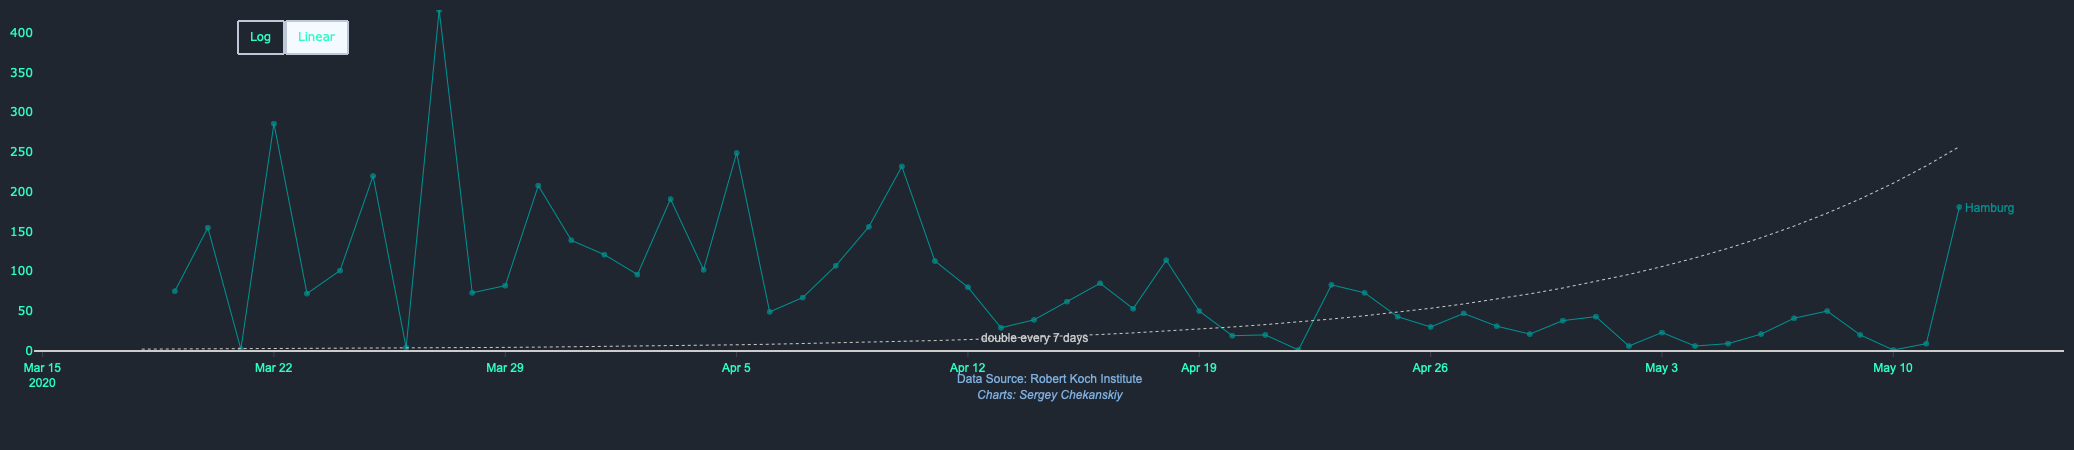

In [377]:
from numpy import log10, datetime64, dtype
import pandas as pd
import plotly
import plotly.graph_objects as go
from plotly.validators.scatter.marker import SymbolValidator


def plot_lines_plotly(df_unfiltered, lands, column, title=False, show_doubling=True, doubling_days=7, showlegend=False):

    df = df_unfiltered.loc[df_unfiltered.land.isin(lands), ['land', column]]  # .sort_values('confirmed_change')

    _doubling_column = f'_doubling_column'

    if show_doubling:
        def double_every_x_days(day, days_doubling):
            r = 1 * 2 ** (day / days_doubling)
            return r

        date_range = pd.date_range(df_unfiltered.index.min(), df_unfiltered.index.max())
        df_index = pd.DataFrame(columns=['date', 'land', column],
                                data={'date': date_range, 'land': _doubling_column},
                                )
        df_index['rn'] = df_index.groupby('land')['date'].rank(method='first', ascending=True)
        df_index[column] = df_index['rn'].apply(lambda x: double_every_x_days(x, doubling_days))
        df_index['date'] = df_index['date'].astype('datetime64[ns]')
        df_index.set_index('date', inplace=True, drop=False)
        df_index.sort_index(inplace=True, ascending=True)
        del df_index['rn']
        # del df_index['date']
        df = df.append(df_index, ignore_index=False, verify_integrity=False, sort=True)
        df = df.rename_axis('dates_index') #.sort_values(by=['land', 'dates_index'], ascending=[True, True])
        
    print(df.index)
    del df_unfiltered

    # Create traces
    fig = go.Figure()

    _labels = df['land'].unique()

    #     max_x_range = len(df.index)
    _max_y_range = df[column].max()

    _colors = plotly.colors.diverging.Temps * 3  # ['rgb(67,67,67)', 'rgb(115,115,115)', 'rgb(49,130,189)', 'rgb(189,189,189)']
    _symbols = [x for i, x in enumerate(SymbolValidator().values) if i % 2 != 0]  # all markers
    _gray_color = 'rgb(204, 204, 204)'

    _mode_size = [8] * len(_labels)  # [8, 8, 12, 8]
    _line_size = [1] * len(_labels)  # [2, 2, 4, 2]

    for i, l in enumerate(_labels):
        # Adding Doubling x7 line
        if l == _doubling_column:
            fig.add_trace(go.Scatter(x=df.loc[df.land == l].index,
                                     y=df.loc[df.land == l, column],
                                     mode='lines',
                                     marker=dict(color=_gray_color,
                                                 size=_mode_size[i] - 2,
                                                 opacity=0.7,
                                                 symbol=_symbols[i + 2],
                                                 line=dict(
                                                     color=_colors[i],
                                                     width=1
                                                 )
                                                 ),
                                     name=l,
                                     line=dict(color=_gray_color,
                                               width=_line_size[i],
                                               dash='dot', ),
                                     connectgaps=True,
                                     ))

        # Adding all other lines
        else:
            fig.add_trace(go.Scatter(x=df.loc[df.land == l].index,
                                     y=df.loc[df.land == l, column],
                                     mode='lines+markers',
                                     marker=dict(color=_colors[i],
                                                 size=_mode_size[i] - 3,
                                                 opacity=0.7,
                                                 symbol=_symbols[i + 2],
                                                 line=dict(
                                                     color=_colors[i],
                                                     width=1
                                                 )
                                                 ),
                                     name=l,
                                     line=dict(color=_colors[i],
                                               width=_line_size[i]),
                                     connectgaps=False,
                                     ))

            # endpoints
            min_index, max_index = df.loc[df.land == l].index.min(), df.loc[df.land == l].index.max()
            fig.add_trace(go.Scatter(
                x=[min_index, max_index],
                y=[df.loc[(df.index == min_index) & (df.land == l)], df.loc[(df.index == max_index) & (df.land == l)]],
                mode='markers',
                name=l,
                marker=dict(color=_colors[i], size=_mode_size[i] + 2, ),
                showlegend=False,
            ))

    # BUTTONS Changing Y Scale
    updatemenus = list([
        dict(active=1,
             direction="left",
             buttons=list([
                 dict(label='Log',
                      method='update',
                      args=[{'visible': [True, True]},
                            {  # 'title': 'Log scale',
                                'yaxis': {'type': 'log', 'range': [0, log10(_max_y_range)],
                                          'showgrid': False,
                                          'zeroline': False,
                                          'showline': False,
                                          'linecolor': '#1f2630',
                                          }}
                            ]
                      ),
                 dict(label='Linear',
                      method='update',
                      args=[{'visible': [True, True]},
                            {  # 'title': 'Linear scale',
                                'yaxis': {'type': 'linear', 'range': [0, _max_y_range],
                                          # 'showticklabels': False,
                                          'showgrid': False,
                                          'zeroline': False,
                                          'showline': False,
                                          'linecolor': '#1f2630',
                                          }}
                            ]
                      ),
             ]),
             type='buttons',
             pad={"r": 10, "t": 10},
             showactive=True,
             x=0.10,
             xanchor="left",  # ['auto', 'left', 'center', 'right']
             y=1,
             yanchor='top',  # ['auto', 'top', 'middle', 'bottom']
             )
    ])

    # UPDATE LAYOUT, Axis, Margins, Size, Legend, Background
    fig.update_layout(
        updatemenus=updatemenus,
        xaxis=dict(
            showline=True,
            showgrid=False,
            showticklabels=True,
            linecolor=_gray_color,
            linewidth=2,
            ticks='outside',
            tickfont=dict(
                family='Arial',
                size=12,
                color='#2cfec1',  # 'rgb(82, 82, 82)',
            ),
            #                 range=[0,max_x_range],
        ),
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            showline=False,
            showticklabels=True,
            tickfont=dict(color='#2cfec1'),
            range=[0, _max_y_range],
        ),
        margin=dict(
            autoexpand=True,
            l=10,
            r=10,
            t=10,
            b=100,
        ),
        showlegend=showlegend,
        legend_orientation="v",
        legend=dict(
            x=1.05,
            y=0, ),
        paper_bgcolor="#1f2630",  # "#F4F4F8",
        plot_bgcolor="#1f2630",  # 'white'
        font=dict(color='#2cfec1'),
        autosize=True,
        # width=800,
        # height=500,
    )

    # ANNOTATIONS
    annotations = []
    # Adding labels
    for i, l in enumerate(_labels):
        min_index, max_index = df.loc[df.land == l].index.min(), df.loc[df.land == l].index.max()
        if l == _doubling_column:
            # labeling x7 line
            x = (min_index + (max_index - min_index) /2)
            try:
                x = str(x.date())
            except:
                pass
            y = df.loc[(df.land == l) & (df.index == x), column].values[0]
            annotations.append(dict(xref='x', x=x, y=y,
                                    xanchor='center', yanchor='middle',
                                    text="double every 7 days",
                                    font=dict(family='Arial',
                                              size=12,
                                              color=_gray_color, ),
                                    showarrow=False))
        else:
            # labeling the left_side of the plot
            #     y = df.loc[(df.land == l) & (df.index == min_index), column]
            #     annotations.append(dict(xref='paper', x=0.07, y=y,
            #                                   xanchor='right', yanchor='middle',
            #                                   text=col + ' {}'.format(y),
            #                                   font=dict(family='Arial',
            #                                             size=10),
            #                                   showarrow=False))

            # labeling the right_side of the plot
            y = df.loc[(df.land == l) & (df.index == max_index), column].values[0]
            annotations.append(dict(xref='paper',
                                    x=0.95,
                                    y=y,
                                    xanchor='left', yanchor='middle',
                                    text=l,  # f"{col}: {int(y)}",
                                    font=dict(family='Arial',
                                              size=12,
                                              color=_colors[i]),
                                    showarrow=False))

    # Title
    if title:
        annotations.append(dict(xref='paper', yref='paper', x=0, y=1,
                                xanchor='left', yanchor='bottom',
                                text=title,
                                font=dict(family='Garamond',
                                          size=30,
                                          color='#7fafdf' #'rgb(37,37,37)'
                                          ),
                                showarrow=False))
    # Source
    annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.06,
                            xanchor='center', yanchor='top',
                            text="<a href='https://www.rki.de/'> Data Source: Robert Koch Institute</a><br><i><a href='https://www.linkedin.com/in/sergeychekanskiy'>Charts: Sergey Chekanskiy</a></i>",
                            font=dict(family='Arial',
                                      size=12,
                                      color='#7fafdf'),
                            showarrow=False))

    fig.update_layout(annotations=annotations)

    fig.show()
plot_lines_plotly(df, ['Hamburg'], column, title=False, show_doubling=True, doubling_days=7, showlegend=False)

In [371]:
min_index, max_index = df.loc[df.land == l].index.min(), df.loc[df.land == l].index.max()
# labeling x7 line
x = (min_index + (max_index - min_index) /2)
print(type(x))
y = df.loc[(df.land == l) & (df.index == str(x)), column]
y

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


Series([], Name: confirmed_change, dtype: float64)

In [338]:
# df = plot_lines_plotly(df, ['Hamburg'], column, title=False, show_doubling=True, doubling_days=7, showlegend=False)
# from plotly.validators.scatter.marker import SymbolValidator

# _labels = df['land'].unique()
# _colors = plotly.colors.diverging.Temps * 3  # ['rgb(67,67,67)', 'rgb(115,115,115)', 'rgb(49,130,189)', 'rgb(189,189,189)']
# _symbols = [x for i, x in enumerate(SymbolValidator().values) if i % 2 != 0]  # all markers
# _mode_size = [8] * len(_labels)  # [8, 8, 12, 8]
# _line_size = [1] * len(_labels)  # [2, 2, 4, 2]
# fig = go.Figure()
# for i, l in enumerate(_labels):
#     fig.add_trace(go.Scatter(x=df.loc[df.land == l].index,
#                              y=df.loc[df.land == l, column],
#                              mode='lines+markers',
#                              marker=dict(color=_colors[i],
#                                          size=_mode_size[i] - 3,
#                                          opacity=0.7,
#                                          symbol=_symbols[i + 2],
#                                          line=dict(
#                                              color=_colors[i],
#                                              width=1
#                                          )
#                                          ),
#                              name=l,
#                              line=dict(color=_colors[i],
#                                        width=_line_size[i]),
#                              connectgaps=False,
#                              ))
# fig.show()